
# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [71]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [72]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import libraries and setup matplotlib

In [73]:
import matplotlib.pylab as plt

# Download tokenizer if not present
import nltk
nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import text_to_sequence, phonetise_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
from hifigandenoiser import Denoiser
%matplotlib inline



[nltk_data] Downloading package punkt to /home/smehta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [113]:
%ls checkpoints/OverFlow_scaled

checkpoint_0.ckpt      checkpoint_1500.ckpt   checkpoint_4000.ckpt
checkpoint_10000.ckpt  checkpoint_15500.ckpt  checkpoint_4500.ckpt
checkpoint_1000.ckpt   checkpoint_16000.ckpt  checkpoint_5000.ckpt
checkpoint_10500.ckpt  checkpoint_16500.ckpt  checkpoint_500.ckpt
checkpoint_11000.ckpt  checkpoint_17000.ckpt  checkpoint_5500.ckpt
checkpoint_11500.ckpt  checkpoint_17500.ckpt  checkpoint_6000.ckpt
checkpoint_12000.ckpt  checkpoint_18000.ckpt  checkpoint_6500.ckpt
checkpoint_12500.ckpt  checkpoint_18500.ckpt  checkpoint_7000.ckpt
checkpoint_13000.ckpt  checkpoint_19000.ckpt  checkpoint_7500.ckpt
checkpoint_13500.ckpt  checkpoint_2000.ckpt   checkpoint_8000.ckpt
checkpoint_14000.ckpt  checkpoint_2500.ckpt   checkpoint_8500.ckpt
checkpoint_14500.ckpt  checkpoint_3000.ckpt   checkpoint_9000.ckpt
checkpoint_15000.ckpt  checkpoint_3500.ckpt   checkpoint_9500.ckpt


In [114]:
checkpoint_path = "checkpoints/OverFlow_scaled/checkpoint_11000.ckpt"

## Plotting code

In [115]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [116]:
hparams = create_hparams()

## Load model from checkpoint

In [117]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [118]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,952,577 trainable parameters


## Load Hifi-gan for mel2audio synthesis and denoiser

In [119]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [120]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'g_02500000'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [121]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval().half()
generator.remove_weight_norm()

denoiser = Denoiser(generator, mode='zeros')

g_02500000
Loading 'g_02500000'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [149]:
model.model.hmm.hparams.max_sampling_time = 4000
model.model.hmm.hparams.duration_quantile_threshold=0.5
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=False
model.model.hmm.hparams.prenet_dropout_while_eval=True

## Set texts

In [150]:
texts = [
    "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS .."
]

In [151]:
test_sentences = {
    1: "; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW.",
    2: "THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON.",
    3: "WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW.",
    4: "IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND.",
    5: "THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS.",
    6: "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS.",
    7: "IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS.",
    8: "IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS.",
    9: "IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING.",
    10: "DISTILLING INTELLIGENCE INTO AN ALGORITHMIC CONSTRUCT AND COMPARING IT TO THE HUMAN BRAIN MIGHT YIELD INSIGHTS.",
    11: "THE VAULT THAT WAS SEARCHED HAD IN FACT BEEN EMPTIED EARLIER THAT SAME DAY.",
    12: "ANT LIVES NEXT TO GRASSHOPPER, ANT SAYS, I LIKE TO WORK EVERY DAY.",
    13: "YOUR MEANS OF TRANSPORT FULFIL ECONOMIC REQUIREMENTS IN YOUR CHOSEN COUNTRY.",
    14: "SLEEP STILL FOGGED MY MIND AND ATTEMPTED TO FIGHT BACK THE PANIC.",
    15: "SUDDENLY, I SAW TWO FAST AND FURIOUS ; FEET DRIBBLING THE ; BALL TOWARDS MY GOAL.",
}

texts = list(test_sentences.values())

In [164]:
texts = [
    "We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics."
]

In [165]:
sequences = []

for i, text in enumerate(texts):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = phonetise_text(hparams.cmu_phonetiser, text, word_tokenize)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device).long()
    sequences.append(sequence)
    
    print(''.join(['='] * 100))


********************
1 - Input text: 
********************
We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics

********************
1 - Phonetised text: 
********************
{W IY1} {P R AH0 P OW1 Z} {AH0} {N UW1} {AH0 P R OW1 CH} , {OW1 V ER0 F L OW2} , {T UW1} {AE1 D R EH2 S} {DH AH0} {SH AO1 R T K AH2 M IH0 NG Z} {AH1 V} {N UH1 R AH0 L} {HH AH0 M} TTS ( {AH0} {T AY1 P} {AH1 V} {T R AE0 N S D UW1 S ER0} TTS ) {B AY1} {AE1 D IH0 NG} {F L OW1 Z} {OW1 V ER0} {DH EH1 M} . {HH AE1 V IH0 NG} {AH0} {S T R AO1 NG G ER0} probabilistic {M AA1 D AH0 L} , {W IY1} {K AE1 N} {N AW1} {D IH0 S K R AY1 B} {DH AH0} {HH AY1 L IY0} non-Gaussian {D IH2 S T R AH0 B Y UW1 SH AH0 N} {AH1 V} {S P IY1 CH} {AH0 K UW1 S T IH0 K S}


## Decode text input and plot results

In [166]:
t = 0.334

In [167]:
from tqdm.auto import tqdm
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all = [], []
    for sequence in tqdm(sequences, leave=False):
        mel_output, hidden_state_travelled, _, _ = model.sample(sequence.squeeze(0), sampling_temp=t)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)
        

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualisations of the output

0 We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics


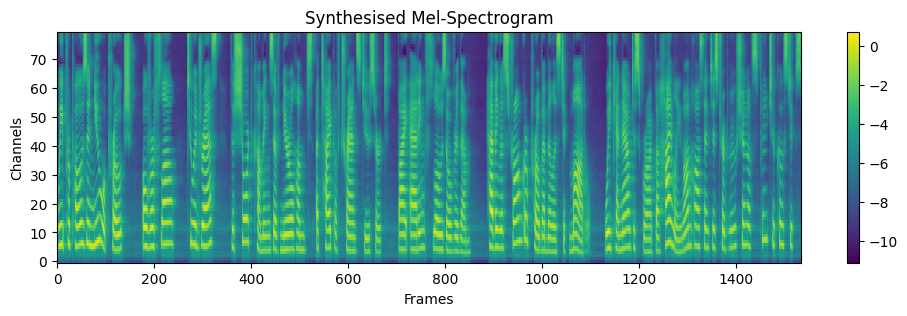

In [168]:
for i, mel_output in enumerate(mel_outputs):
    print(i, texts[i])
    plot_spectrogram_to_numpy(np.array(mel_output.float().cpu()).T)

### Synthesize audio from spectrogram using HiFiGAN

### Interesting denoising

In [169]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = mel_output.transpose(1, 2)
        audio = generator(mel_output)
        audio = denoiser(audio[:, 0], strength=0.004)[:, 0]
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics


***********************************



### Save to wav files using soundfile

In [ ]:
import soundfile as sf
from pathlib import Path

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
        filename = basepath / f'OverFlow_{i + 1}.wav'
        sr = 22500
        sf.write(filename, audio.data.squeeze().cpu().numpy(), 
                 22500, 'PCM_24')
        print(f'Successfully written: {filename}')
